# Data Transformation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import Binarizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import MinMaxScaler

%config IPCompleter.greedy=True

In [2]:

cat = pd.read_pickle('../../02_Data/03_Work/cat_result_quality.pickle')
num = pd.read_pickle('../../02_Data/03_Work/num_result_quality.pickle')


From previous phases we know that we have to:
(with pandas)
- Create target from state
- discretize months_since_last_delinquency
- in 'housing', join NONE and OTHER
- in 'purpose', join renewable_energy, educational and vacation.
(with scikit learn)
- we could work around 'description' with a TF-IDF Vectorizer
- convert num_derogatories to binary


## Creating variables and transformations with pandas

### Target for the PD model

In [3]:
cat.status.value_counts()

status
Fully Paid                                             66303
Current                                                54059
Charged Off                                            16411
Late (31-120 days)                                      1307
In Grace Period                                          533
Late (16-30 days)                                        270
Does not meet the credit policy. Status:Fully Paid       108
Does not meet the credit policy. Status:Charged Off       63
Default                                                    2
Name: count, dtype: int64

**Probability of Default** (PD) is the probability that a customer has to generate a default (delay of 90 days in the payment)

In [4]:
cat['target_pd'] = np.where(cat.status.isin(['Charged Off',
                                            'Does not meet the credit policy. Status:Charged Off',
                                            'Default']), 1, 0)
cat

,employment,employment_duration,verified_income,rating,housing,description,purpose,num_installments,status,target_pd
client_id,,,,,,,,,,
59561505,unknown,unknown,Verified,E,MORTGAGE,unknown,debt_consolidation,36 months,Fully Paid,0
443000,Clark County Nevada,2 years,Source Verified,C,RENT,In the last couple of months the interest rate...,credit_card,36 months,Fully Paid,0
27640646,AVP Finance,7 years,Source Verified,B,MORTGAGE,unknown,debt_consolidation,60 months,Fully Paid,0
31327120,RN,2 years,Not Verified,C,RENT,unknown,debt_consolidation,36 months,Fully Paid,0
94241181,Hotel Leader,10+ years,Verified,C,RENT,unknown,debt_consolidation,36 months,Charged Off,1
...,...,...,...,...,...,...,...,...,...,...
51876926,Office Manager,10+ years,Not Verified,C,MORTGAGE,unknown,debt_consolidation,36 months,Fully Paid,0
121031962,Owner & President,6 years,Verified,B,MORTGAGE,unknown,other,36 months,Current,0
135641397,Sr. Field Engineer,10+ years,Source Verified,D,MORTGAGE,unknown,small_business,36 months,Current,0


In [5]:
cat.drop(columns = 'status', inplace=True) 
# we won't need status anymore

### Target for the EAD model

Percentage from the principal that wasn't amortized (how much they still owe on the loan at the time of default). 

So: remaining/principal

In [6]:
num['remaining'] = num.principal - num.amount_amortized
num

,income,dti,num_mortgages,num_credit_lines,pct_cards_75p,pct_revolving_utilization,num_cancellations_12months,num_derogatories,months_since_last_delinquency,principal,interest_rate,installment_amount,amount_amortized,amount_recovered,remaining
client_id,,,,,,,,,,,,,,,
59561505,36000.0,29.93,2.0,12.0,60.0,66.0,0.0,0.0,0.0,15100.0,18.25,547.80,15100.00,0.00,0.00
443000,59363.0,14.47,0.0,5.0,0.0,59.8,0.0,0.0,0.0,6000.0,13.22,202.81,6000.00,0.00,0.00
27640646,240000.0,7.74,5.0,16.0,20.0,34.1,0.0,0.0,0.0,24000.0,12.49,539.83,24000.00,0.00,0.00
31327120,61000.0,35.27,3.0,16.0,60.0,50.2,0.0,0.0,13.0,5600.0,14.65,193.17,5600.00,0.00,0.00
94241181,77000.0,16.95,2.0,14.0,60.0,49.4,0.0,0.0,30.0,9000.0,14.99,311.95,2563.02,0.00,6436.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51876926,42000.0,20.85,6.0,9.0,100.0,81.6,0.0,0.0,13.0,8000.0,12.29,266.83,8000.00,0.00,0.00
121031962,111697.0,16.63,2.0,10.0,50.0,26.3,0.0,1.0,6.0,10000.0,9.44,320.05,4388.51,0.00,5611.49
135641397,285000.0,6.02,3.0,9.0,25.0,21.1,0.0,0.0,25.0,30000.0,17.47,1076.62,5387.53,0.00,24612.47


In [7]:
num['target_ead'] = num.remaining / num.principal
num

,income,dti,num_mortgages,num_credit_lines,pct_cards_75p,pct_revolving_utilization,num_cancellations_12months,num_derogatories,months_since_last_delinquency,principal,interest_rate,installment_amount,amount_amortized,amount_recovered,remaining,target_ead
client_id,,,,,,,,,,,,,,,,
59561505,36000.0,29.93,2.0,12.0,60.0,66.0,0.0,0.0,0.0,15100.0,18.25,547.80,15100.00,0.00,0.00,0.000000
443000,59363.0,14.47,0.0,5.0,0.0,59.8,0.0,0.0,0.0,6000.0,13.22,202.81,6000.00,0.00,0.00,0.000000
27640646,240000.0,7.74,5.0,16.0,20.0,34.1,0.0,0.0,0.0,24000.0,12.49,539.83,24000.00,0.00,0.00,0.000000
31327120,61000.0,35.27,3.0,16.0,60.0,50.2,0.0,0.0,13.0,5600.0,14.65,193.17,5600.00,0.00,0.00,0.000000
94241181,77000.0,16.95,2.0,14.0,60.0,49.4,0.0,0.0,30.0,9000.0,14.99,311.95,2563.02,0.00,6436.98,0.715220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51876926,42000.0,20.85,6.0,9.0,100.0,81.6,0.0,0.0,13.0,8000.0,12.29,266.83,8000.00,0.00,0.00,0.000000
121031962,111697.0,16.63,2.0,10.0,50.0,26.3,0.0,1.0,6.0,10000.0,9.44,320.05,4388.51,0.00,5611.49,0.561149
135641397,285000.0,6.02,3.0,9.0,25.0,21.1,0.0,0.0,25.0,30000.0,17.47,1076.62,5387.53,0.00,24612.47,0.820416


### Target for the LGD model

Lost Given Default

Percentage of the remaining that is NOT recovered if there's default.

In [8]:
num['target_lgd'] = 1 - (num.amount_recovered / num.remaining)
num

,income,dti,num_mortgages,num_credit_lines,pct_cards_75p,pct_revolving_utilization,num_cancellations_12months,num_derogatories,months_since_last_delinquency,principal,interest_rate,installment_amount,amount_amortized,amount_recovered,remaining,target_ead,target_lgd
client_id,,,,,,,,,,,,,,,,,
59561505,36000.0,29.93,2.0,12.0,60.0,66.0,0.0,0.0,0.0,15100.0,18.25,547.80,15100.00,0.00,0.00,0.000000,NaN
443000,59363.0,14.47,0.0,5.0,0.0,59.8,0.0,0.0,0.0,6000.0,13.22,202.81,6000.00,0.00,0.00,0.000000,NaN
27640646,240000.0,7.74,5.0,16.0,20.0,34.1,0.0,0.0,0.0,24000.0,12.49,539.83,24000.00,0.00,0.00,0.000000,NaN
31327120,61000.0,35.27,3.0,16.0,60.0,50.2,0.0,0.0,13.0,5600.0,14.65,193.17,5600.00,0.00,0.00,0.000000,NaN
94241181,77000.0,16.95,2.0,14.0,60.0,49.4,0.0,0.0,30.0,9000.0,14.99,311.95,2563.02,0.00,6436.98,0.715220,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51876926,42000.0,20.85,6.0,9.0,100.0,81.6,0.0,0.0,13.0,8000.0,12.29,266.83,8000.00,0.00,0.00,0.000000,NaN
121031962,111697.0,16.63,2.0,10.0,50.0,26.3,0.0,1.0,6.0,10000.0,9.44,320.05,4388.51,0.00,5611.49,0.561149,1.000000
135641397,285000.0,6.02,3.0,9.0,25.0,21.1,0.0,0.0,25.0,30000.0,17.47,1076.62,5387.53,0.00,24612.47,0.820416,1.000000


In [9]:
# there's nulls where remaining is 0, we can impute them for zeros

num['target_lgd'] = num['target_lgd'].fillna(0)
num

,income,dti,num_mortgages,num_credit_lines,pct_cards_75p,pct_revolving_utilization,num_cancellations_12months,num_derogatories,months_since_last_delinquency,principal,interest_rate,installment_amount,amount_amortized,amount_recovered,remaining,target_ead,target_lgd
client_id,,,,,,,,,,,,,,,,,
59561505,36000.0,29.93,2.0,12.0,60.0,66.0,0.0,0.0,0.0,15100.0,18.25,547.80,15100.00,0.00,0.00,0.000000,0.000000
443000,59363.0,14.47,0.0,5.0,0.0,59.8,0.0,0.0,0.0,6000.0,13.22,202.81,6000.00,0.00,0.00,0.000000,0.000000
27640646,240000.0,7.74,5.0,16.0,20.0,34.1,0.0,0.0,0.0,24000.0,12.49,539.83,24000.00,0.00,0.00,0.000000,0.000000
31327120,61000.0,35.27,3.0,16.0,60.0,50.2,0.0,0.0,13.0,5600.0,14.65,193.17,5600.00,0.00,0.00,0.000000,0.000000
94241181,77000.0,16.95,2.0,14.0,60.0,49.4,0.0,0.0,30.0,9000.0,14.99,311.95,2563.02,0.00,6436.98,0.715220,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51876926,42000.0,20.85,6.0,9.0,100.0,81.6,0.0,0.0,13.0,8000.0,12.29,266.83,8000.00,0.00,0.00,0.000000,0.000000
121031962,111697.0,16.63,2.0,10.0,50.0,26.3,0.0,1.0,6.0,10000.0,9.44,320.05,4388.51,0.00,5611.49,0.561149,1.000000
135641397,285000.0,6.02,3.0,9.0,25.0,21.1,0.0,0.0,25.0,30000.0,17.47,1076.62,5387.53,0.00,24612.47,0.820416,1.000000


In [10]:
cat['target_pd'].mean()

0.11848463928201587

In [11]:
num[['target_ead','target_lgd']].describe().T

,count,mean,std,min,25%,50%,75%,max
target_ead,139056.0,0.337315,0.369200,-0.000003,0.0,0.128457,0.725234,1.0
target_lgd,139056.0,0.508093,0.490401,-0.248392,0.0,0.848439,1.000000,1.0


### Rest of the variables

In [12]:
temp = num[['months_since_last_delinquency']].copy()

In [13]:

temp['months_since_last_delinquency'] = pd.cut(temp['months_since_last_delinquency'],20)
temp['target'] = cat['target_pd']


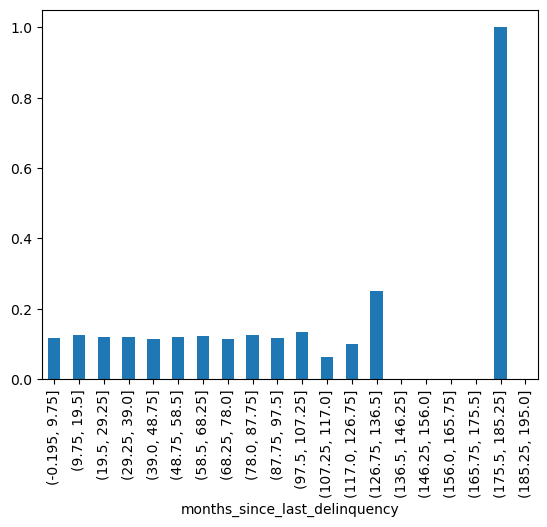

In [14]:
temp.groupby('months_since_last_delinquency',observed=False).target.mean().plot.bar();

Not very trustworthy, o we discard it

In [15]:
num.drop(columns = 'months_since_last_delinquency', inplace=True)

In [16]:
# Merge ANY NONE and OTHER in housing

cat.housing.value_counts()



housing
MORTGAGE    68008
RENT        55486
OWN         15509
ANY            43
OTHER           9
NONE            1
Name: count, dtype: int64

In [17]:
cat.housing = cat.housing.replace(['ANY', 'NONE', 'OTHER'], 'MORTGAGE')

In [18]:
cat.housing.value_counts()

housing
MORTGAGE    68061
RENT        55486
OWN         15509
Name: count, dtype: int64

In [19]:
# purpose 'other'

cat.purpose.value_counts()


purpose
debt_consolidation    79036
credit_card           31365
home_improvement       9028
other                  8659
major_purchase         3118
medical                1654
small_business         1588
car                    1442
moving                 1002
vacation                997
house                   915
wedding                 149
renewable_energy         74
educational              29
Name: count, dtype: int64

In [20]:

cat.purpose = cat.purpose.replace(['wedding','educational','renewable_energy'], 'other')


In [21]:
cat.purpose.value_counts()

purpose
debt_consolidation    79036
credit_card           31365
home_improvement       9028
other                  8911
major_purchase         3118
medical                1654
small_business         1588
car                    1442
moving                 1002
vacation                997
house                   915
Name: count, dtype: int64

## Transformation: Categorics

#### One hot encoding

In [22]:
var_ohe = [ 'verified_income', 
           'housing',
           'purpose',
           'num_installments']

In [23]:
ohe = OneHotEncoder(sparse_output= False,
                   handle_unknown='ignore')

In [24]:
cat_ohe = ohe.fit_transform(cat[var_ohe])

In [25]:
cat_ohe = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names_out())

In [26]:
cat_ohe

,verified_income_Not Verified,verified_income_Source Verified,verified_income_Verified,housing_MORTGAGE,housing_OWN,housing_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,num_installments_ 36 months,num_installments_ 60 months
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139051,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
139052,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
139053,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
139054,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


#### Ordinal Encoding

In [27]:
var_oe = ['employment_duration','rating']

In [28]:
order_empl_duration = ['unknown',
                       '< 1 year',
                       '1 year',
                       '2 years',
                       '3 years',
                       '4 years',
                       '5 years',
                       '6 years',
                       '7 years',
                       '8 years',
                       '9 years',
                       '10+ years']

order_rating = ['A','B','C','D','E','F','G']

In [29]:

oe = OrdinalEncoder(categories=[order_empl_duration, order_rating],
                   handle_unknown='use_encoded_value',
                   unknown_value=12)

cat_oe = oe.fit_transform(cat[var_oe])

# save dataframe
names_oe = [variable + '_oe' for variable in var_oe]
cat_oe = pd.DataFrame(cat_oe, columns = names_oe)


In [30]:
cat_oe

,employment_duration_oe,rating_oe
0,0.0,4.0
1,3.0,2.0
2,8.0,1.0
3,3.0,2.0
4,11.0,2.0
...,...,...
139051,11.0,2.0
139052,7.0,1.0
139053,11.0,3.0
139054,9.0,4.0


#### Texts

In [31]:
stopwords = pd.read_csv('../../01_Documents/stop_words_english.txt',names = ['term'])


In [32]:
# apply tf-idf

tfidf = TfidfVectorizer(strip_accents = 'unicode',
                     stop_words = stopwords.term.to_list(),
                     max_df = 0.7,
                     min_df = 50,
                     ngram_range = (1,3),
                     max_features = 50)

description = tfidf.fit_transform(cat.description)


/home/adrian/miniconda3/envs/risks/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'al', 'couldn', 'daren', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'itse', 'll', 'mayn', 'mightn', 'mon', 'mustn', 'myse', 'needn', 'oughtn', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [33]:
tfidf.vocabulary_

{'rate': 47,
 'credit': 31,
 'cards': 28,
 'payments': 46,
 'card': 26,
 'years': 49,
 'credit cards': 34,
 'credit card': 32,
 'borrower': 15,
 '07': 6,
 '10': 9,
 'loan': 38,
 'consolidate': 29,
 'debt': 35,
 'br': 22,
 'borrower 07': 19,
 '11': 10,
 '13': 12,
 '06': 5,
 '04': 3,
 '12': 11,
 'pay': 42,
 '05': 4,
 'bills': 14,
 'pay credit': 43,
 'br br': 24,
 'br borrower': 23,
 'br br borrower': 25,
 'paying': 44,
 'month': 40,
 'consolidation': 30,
 'payment': 45,
 'job': 37,
 'monthly': 41,
 'time': 48,
 'high': 36,
 '01': 0,
 'borrower 01': 16,
 'money': 39,
 '03': 2,
 'borrower 10': 20,
 '02': 1,
 'borrower 02': 17,
 '08': 7,
 '14': 13,
 '09': 8,
 'card debt': 27,
 'credit card debt': 33,
 'borrower 12': 21,
 'borrower 03': 18}

In [34]:
# doesn't seem to add anything new
# we are not going to include it

## Transformation: Categorics

In [35]:
var_bin = ['num_derogatories']
bin = Binarizer(threshold=0)
num_bin = bin.fit_transform(num[var_bin])

In [36]:
names_bin = [variable + '_bin' for variable in var_bin]
num_bin = pd.DataFrame(num_bin,columns = names_bin)

#### Rescale

In [37]:
# minmax

num_scale = num[['income',
                  'dti',
                  'num_credit_lines',
                  'pct_revolving_utilization',
                  'principal',
                  'interest_rate',
                  'installment_amount']].reset_index(drop=True)



In [38]:
df_res = pd.concat([cat_oe, num_scale], axis=1)
# we apply minmax also to the Ordinal Encoded

In [39]:
df_res

,employment_duration_oe,rating_oe,income,dti,num_credit_lines,pct_revolving_utilization,principal,interest_rate,installment_amount
0,0.0,4.0,36000.0,29.93,12.0,66.0,15100.0,18.25,547.80
1,3.0,2.0,59363.0,14.47,5.0,59.8,6000.0,13.22,202.81
2,8.0,1.0,240000.0,7.74,16.0,34.1,24000.0,12.49,539.83
3,3.0,2.0,61000.0,35.27,16.0,50.2,5600.0,14.65,193.17
4,11.0,2.0,77000.0,16.95,14.0,49.4,9000.0,14.99,311.95
...,...,...,...,...,...,...,...,...,...
139051,11.0,2.0,42000.0,20.85,9.0,81.6,8000.0,12.29,266.83
139052,7.0,1.0,111697.0,16.63,10.0,26.3,10000.0,9.44,320.05
139053,11.0,3.0,285000.0,6.02,9.0,21.1,30000.0,17.47,1076.62
139054,9.0,4.0,168000.0,4.69,8.0,52.4,30050.0,18.25,767.17


In [40]:
# scaler
mms = MinMaxScaler()

In [41]:
df_mms = mms.fit_transform(df_res)

In [42]:

names_mms = [variable + '_mms' for variable in df_res.columns]
df_mms = pd.DataFrame(df_mms,columns = names_mms)


In [43]:
df_mms

,employment_duration_oe_mms,rating_oe_mms,income_mms,dti_mms,num_credit_lines_mms,pct_revolving_utilization_mms,principal_mms,interest_rate_mms,installment_amount_mms
0,0.000000,0.666667,0.120000,0.03093,0.142857,0.357530,0.369620,0.503894,0.316469
1,0.272727,0.333333,0.197877,0.01547,0.059524,0.323944,0.139241,0.308022,0.114357
2,0.727273,0.166667,0.800000,0.00874,0.190476,0.184724,0.594937,0.279595,0.311800
3,0.272727,0.333333,0.203333,0.03627,0.190476,0.271939,0.129114,0.363707,0.108710
4,1.000000,0.333333,0.256667,0.01795,0.166667,0.267606,0.215190,0.376947,0.178297
...,...,...,...,...,...,...,...,...,...
139051,1.000000,0.333333,0.140000,0.02185,0.107143,0.442037,0.189873,0.271807,0.151863
139052,0.636364,0.166667,0.372323,0.01763,0.119048,0.142470,0.240506,0.160826,0.183042
139053,1.000000,0.500000,0.950000,0.00702,0.107143,0.114301,0.746835,0.473520,0.626276
139054,0.818182,0.666667,0.560000,0.00569,0.095238,0.283857,0.748101,0.503894,0.444986


## Unify datasets

In [44]:

include_pd = [cat_ohe, 
              cat_oe, 
              df_mms, 
              num_bin, 
              cat.reset_index()[['client_id','target_pd']]]



In [47]:
df_pd = pd.concat(include_pd, axis = 1)
df_pd.set_index('client_id',inplace=True)

In [48]:
df_pd

,verified_income_Not Verified,verified_income_Source Verified,verified_income_Verified,housing_MORTGAGE,housing_OWN,housing_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,...,rating_oe_mms,income_mms,dti_mms,num_credit_lines_mms,pct_revolving_utilization_mms,principal_mms,interest_rate_mms,installment_amount_mms,num_derogatories_bin,target_pd
client_id,,,,,,,,,,,,,,,,,,,,,
59561505,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.666667,0.120000,0.03093,0.142857,0.357530,0.369620,0.503894,0.316469,0.0,0
443000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.333333,0.197877,0.01547,0.059524,0.323944,0.139241,0.308022,0.114357,0.0,0
27640646,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.166667,0.800000,0.00874,0.190476,0.184724,0.594937,0.279595,0.311800,0.0,0
31327120,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.333333,0.203333,0.03627,0.190476,0.271939,0.129114,0.363707,0.108710,0.0,0
94241181,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.333333,0.256667,0.01795,0.166667,0.267606,0.215190,0.376947,0.178297,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51876926,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.333333,0.140000,0.02185,0.107143,0.442037,0.189873,0.271807,0.151863,0.0,0
121031962,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.166667,0.372323,0.01763,0.119048,0.142470,0.240506,0.160826,0.183042,1.0,0
135641397,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.500000,0.950000,0.00702,0.107143,0.114301,0.746835,0.473520,0.626276,0.0,0


In [50]:
include_ead = [cat_ohe, 
               cat_oe, 
               df_mms, 
               num_bin, 
               num.reset_index()[['client_id','target_ead']]]


In [51]:
df_ead = pd.concat(include_ead, axis = 1)
df_ead.set_index('client_id',inplace=True)
df_ead

,verified_income_Not Verified,verified_income_Source Verified,verified_income_Verified,housing_MORTGAGE,housing_OWN,housing_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,...,rating_oe_mms,income_mms,dti_mms,num_credit_lines_mms,pct_revolving_utilization_mms,principal_mms,interest_rate_mms,installment_amount_mms,num_derogatories_bin,target_ead
client_id,,,,,,,,,,,,,,,,,,,,,
59561505,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.666667,0.120000,0.03093,0.142857,0.357530,0.369620,0.503894,0.316469,0.0,0.000000
443000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.333333,0.197877,0.01547,0.059524,0.323944,0.139241,0.308022,0.114357,0.0,0.000000
27640646,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.166667,0.800000,0.00874,0.190476,0.184724,0.594937,0.279595,0.311800,0.0,0.000000
31327120,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.333333,0.203333,0.03627,0.190476,0.271939,0.129114,0.363707,0.108710,0.0,0.000000
94241181,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.333333,0.256667,0.01795,0.166667,0.267606,0.215190,0.376947,0.178297,0.0,0.715220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51876926,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.333333,0.140000,0.02185,0.107143,0.442037,0.189873,0.271807,0.151863,0.0,0.000000
121031962,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.166667,0.372323,0.01763,0.119048,0.142470,0.240506,0.160826,0.183042,1.0,0.561149
135641397,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.500000,0.950000,0.00702,0.107143,0.114301,0.746835,0.473520,0.626276,0.0,0.820416


In [52]:
incluir_lgd = [cat_ohe, 
               cat_oe, 
               df_mms, 
               num_bin, 
               num.reset_index()[['client_id','target_lgd']]]


In [53]:
df_lgd = pd.concat(incluir_lgd, axis = 1)
df_lgd.set_index('client_id',inplace=True)
df_lgd

,verified_income_Not Verified,verified_income_Source Verified,verified_income_Verified,housing_MORTGAGE,housing_OWN,housing_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,...,rating_oe_mms,income_mms,dti_mms,num_credit_lines_mms,pct_revolving_utilization_mms,principal_mms,interest_rate_mms,installment_amount_mms,num_derogatories_bin,target_lgd
client_id,,,,,,,,,,,,,,,,,,,,,
59561505,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.666667,0.120000,0.03093,0.142857,0.357530,0.369620,0.503894,0.316469,0.0,0.000000
443000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.333333,0.197877,0.01547,0.059524,0.323944,0.139241,0.308022,0.114357,0.0,0.000000
27640646,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.166667,0.800000,0.00874,0.190476,0.184724,0.594937,0.279595,0.311800,0.0,0.000000
31327120,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.333333,0.203333,0.03627,0.190476,0.271939,0.129114,0.363707,0.108710,0.0,0.000000
94241181,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.333333,0.256667,0.01795,0.166667,0.267606,0.215190,0.376947,0.178297,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51876926,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.333333,0.140000,0.02185,0.107143,0.442037,0.189873,0.271807,0.151863,0.0,0.000000
121031962,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.166667,0.372323,0.01763,0.119048,0.142470,0.240506,0.160826,0.183042,1.0,1.000000
135641397,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.500000,0.950000,0.00702,0.107143,0.114301,0.746835,0.473520,0.626276,0.0,1.000000


## Save transformed datasets

In [54]:

df_pd.to_pickle('../../02_Data/03_Work/df_board_pd.pickle')
df_ead.to_pickle('../../02_Data/03_Work/df_board_ead.pickle')
df_lgd.to_pickle('../../02_Data/03_Work/df_board_lgd.pickle')
